# Finding the largest Change in Rank vector

## Imports

In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
from itertools import permutations
import math

## Draw graph from adjacency matrix

In [2]:
def draw_graph(adj_matrix):
    G = nx.DiGraph()
    G.add_nodes_from(range(len(adj_matrix)))

    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix[i])):
            if adj_matrix[i][j] == 1:
                G.add_edge(i, j) 

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightpink', node_size=500, font_weight='bold', arrows=True)
    plt.show()

## Ranking algorithms

In [3]:
def in_degree_algorithm(adj_matrix):
    num_nodes = len(adj_matrix)
    indegree = [0] * num_nodes  

    # Calculate indegree for each node
    for i in range(num_nodes):
        for j in range(num_nodes):
            indegree[i] += adj_matrix[j][i]

    # Create a list of tuples (node index, in-degree) and sort by in-degree in descending order
    ranked_pages = [(i, indegree[i]) for i in range(num_nodes)]
    ranked_pages.sort(key=lambda x: x[1], reverse=True)
    
    rankings = [0] * num_nodes
    for i, (node_idx, _) in enumerate(ranked_pages):
        rankings[node_idx] = i + 1  # Assign the ranking to the node
    
    return rankings

In [4]:
def page_rank_algorithm(adjacency_matrix, beta=0.85, k=100, epsilon=1e-8):
    n = len(adjacency_matrix)
    page_rank = np.ones(n) / n
    
    for _ in range(k):
        new_page_rank = np.zeros(n)
        teleportation_factor = (1 - beta) / n
        
        for i in range(n):
            outgoing_links = np.where(adjacency_matrix[i] != 0)[0]
            num_outgoing = len(outgoing_links)
            
            if num_outgoing == 0:
                # Handle spider traps and dead ends
                new_page_rank += teleportation_factor * page_rank[i] / n
            else:
                # Distribute PageRank considering outgoing links and beta
                for link in outgoing_links:
                    new_page_rank[link] += beta * (page_rank[i] / num_outgoing)
        
        # Normalize PageRank scores
        new_page_rank /= np.sum(new_page_rank)
        
        if np.sum(np.abs(new_page_rank - page_rank)) < epsilon:
            break
        
        page_rank = new_page_rank  
    
    # Sort the page ranks and return ordinal rank
    ordinal_ranks = np.argsort(-page_rank)
    ordinal_page_ranks = np.empty(n, dtype=int)
    for i, idx in enumerate(ordinal_ranks):
        ordinal_page_ranks[idx] = i + 1
    
    return ordinal_page_ranks


In [5]:
def get_ordinal_ranks(scores):
    ordinal_ranks = np.argsort(-scores)
    ordinal_page_ranks = np.empty(len(scores), dtype=int)
    for i, idx in enumerate(ordinal_ranks):
        ordinal_page_ranks[idx] = i + 1
    return ordinal_page_ranks

def hits_algorithm(adjacency_matrix, max_iterations=100, tolerance=1.0e-6):
    n = len(adjacency_matrix)
    authority = np.ones(n)
    hub = np.ones(n)
    
    for _ in range(max_iterations):
        prev_authority = authority.copy()
        prev_hub = hub.copy()
        
        # Update authority scores based on hub scores
        authority = np.dot(adjacency_matrix.T, hub)
        
        # Update hub scores based on authority scores
        hub = np.dot(adjacency_matrix, authority)
        
        # Normalize scores
        authority /= np.linalg.norm(authority)
        hub /= np.linalg.norm(hub)
        
        # Check if done
        authority_change = np.linalg.norm(authority - prev_authority)
        hub_change = np.linalg.norm(hub - prev_hub)
        if authority_change < tolerance and hub_change < tolerance:
            break
    
    authority = get_ordinal_ranks(authority)
    hub = get_ordinal_ranks(hub)
    return authority, hub

## Calculate euclidean distance between 2 rank vectors

In [6]:
# Distance between 2 vectors
def vector_distance(vector1, vector2):
    array1 = np.array(vector1)
    array2 = np.array(vector2)

    # Calculate the Euclidean distance
    distance = np.linalg.norm(array1 - array2)
    return distance

## Generate random graph given n nodes, p probability of edge creation

In [7]:
def generate_graph(n,p):
    return nx.erdos_renyi_graph(n, p, directed=True)

## Modify adjacency matrix given indices to be changed

In [8]:
# Modify the matrix given the indices 
def modify_matrix_by_indices(adjacency_matrix, indices_to_change):
    modified_matrix = np.copy(adjacency_matrix)
    for i, j in indices_to_change:
        # If there's an edge remove it, else add an edge
        modified_matrix[i][j] = 1 - modified_matrix[i][j]

    return modified_matrix

In [9]:
# Generate all possible combinations of changes to the adjacency matrix given k
def generate_indices(adjacency_original,k):
    all_indices = [(i, j) for i in range(adjacency_original.shape[0]) for j in range(adjacency_original.shape[1])]
    combinations_indices = list(combinations(all_indices, k))
    return combinations_indices

## Find the highest euclidean distance given original graph, k changes to be made and ranking algorithm

This function performs following steps:
1. Change the networkx graph to adjacency matrix
2. Find the ranking of original graph using the provided algorithm
3. Find all possible adjacency matrix combinations given k changes
4. For each of those changes calculate the ranking of the new graph
5. Calculate the euclidean distance between original ranking and new ranking
6. Return the highest euclidean distance found

In [10]:
def find_highest_distance_after_changes(original_graph, combinations_indices, algorithm):
    max_distance = 0
    modified_matrix = None
    adjacency_original = None
    original_ranking = None
    modified_ranking = None

    # Calculate the ranking of original graph given the algorithm
    adjacency_original_ = nx.adjacency_matrix(original_graph).todense()
    original_ranking_ = algorithm(adjacency_original_)

    if algorithm == hits_algorithm:
        original_ranking_,_  = algorithm(adjacency_original_)
        
    # Iterate over all combination indices
    for selected_indices in combinations_indices:
        # Modify the original graph given the indices
        modified_matrix_ = modify_matrix_by_indices(adjacency_original_, selected_indices)
        # Compute the ranking for the modified matrix
        modified_ranking_ = algorithm(modified_matrix_)

        if algorithm == hits_algorithm:
            modified_ranking_,_  = algorithm(modified_matrix_)

        # Compute the euclidean distance between 2 ranking vectors
        euclidean_distance = vector_distance(original_ranking_, modified_ranking_)
        
        # Update the variables if the new distance is higher 
        if euclidean_distance > max_distance:
            max_distance = euclidean_distance
            modified_matrix = modified_matrix_
            original_ranking = original_ranking_
            modified_ranking = modified_ranking_

    return max_distance, modified_matrix, adjacency_original, original_ranking, modified_ranking

In [11]:
def highest_euclidean_distance_permutations(ranking_original):
# Generate all permutations of v
    all_permutations = list(permutations(ranking_original))

    max_distance = 0
    max_distance_vector = None

    for perm in all_permutations:
        euclidean_distance = vector_distance(ranking_original, perm)
        
        # Update if the current distance is higher than the previous maximum
        if euclidean_distance > max_distance:
            max_distance = euclidean_distance
            max_distance_vector = perm
    return max_distance,max_distance_vector

def highest_euclidean_distance_formula(ranking_original):
    n = int(len(ranking_original))
    return math.sqrt((n*((n**2) - 1))/3)

## Experiment 1: 
Plot a graph for maximum found euclidean distance given graph with n nodes, k values (range) and algorithms

This code plots one random graph given graph size.
For each algorithm and k value it finds the highest euclidean distance.
All results are plotted on the graph.
Note: difficult to check for big graphs and large numbers of k, as the number of combinations grows rapidly.

100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


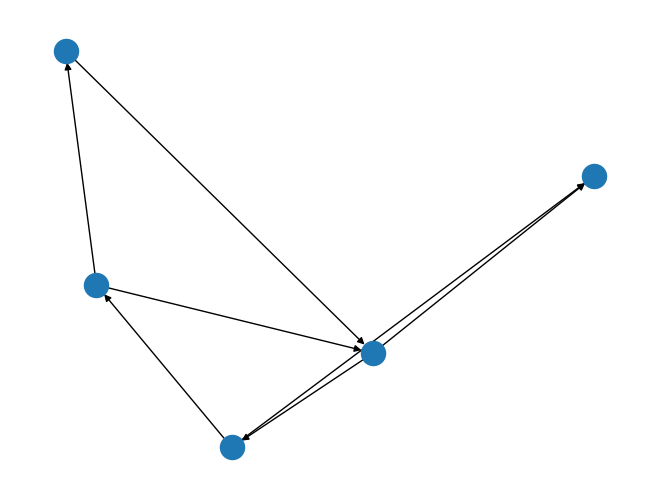

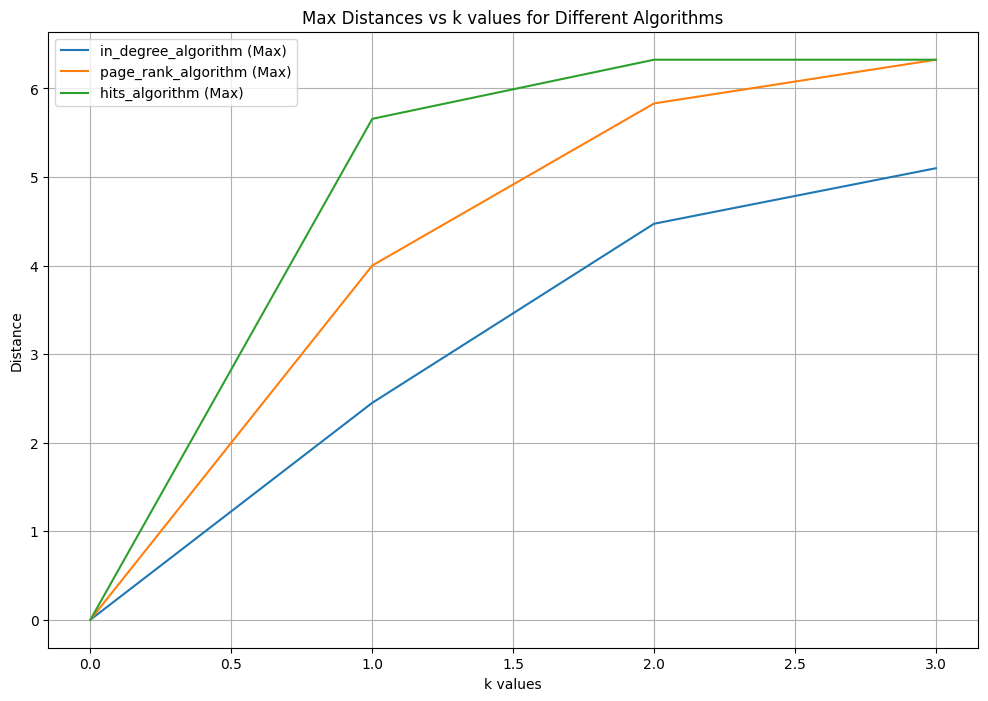

In [57]:
# Paremeters are changed here
list_of_algorithms = [in_degree_algorithm, page_rank_algorithm, hits_algorithm]
graph_size = 5
graph_connectedness = 0.3
k_values = range(0,4)
original_graph = generate_graph(graph_size,graph_connectedness)

combinations_dict = {}
adjacency_original = nx.adjacency_matrix(original_graph).todense()
results = {algorithm.__name__: {'k_values': [], 'max_distances': []} for algorithm in list_of_algorithms}

for k in k_values:
    combinations_dict[k] = generate_indices(adjacency_original,k)

for algorithm in tqdm(list_of_algorithms):
    max_distances = []
    min_distances = []
    for k in k_values:
        max_distance, _, _, _, _ = find_highest_distance_after_changes(original_graph, combinations_dict[k], algorithm)
        max_distances.append(max_distance)
    results[algorithm.__name__]['k_values'] = list(k_values)
    results[algorithm.__name__]['max_distances'] = max_distances

# Plotting
nx.draw(original_graph)
plt.figure(figsize=(12, 8))

for algorithm_name, data in results.items():
    plt.plot(data['k_values'], data['max_distances'], label=f'{algorithm_name} (Max)')

plt.xlabel('k values')
plt.ylabel('Distance')
plt.title('Max Distances vs k values for Different Algorithms')
plt.legend()
plt.grid()
plt.show()

## Experiment 1.1
Consistent indices are changed for all the graphs

100%|██████████| 3/3 [00:00<00:00, 109.95it/s]

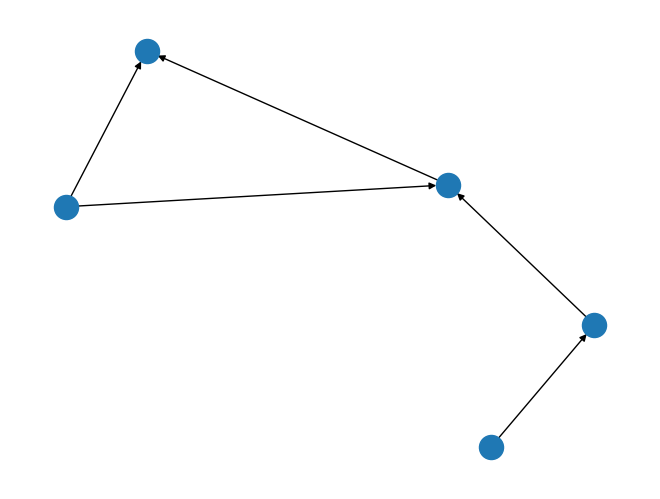

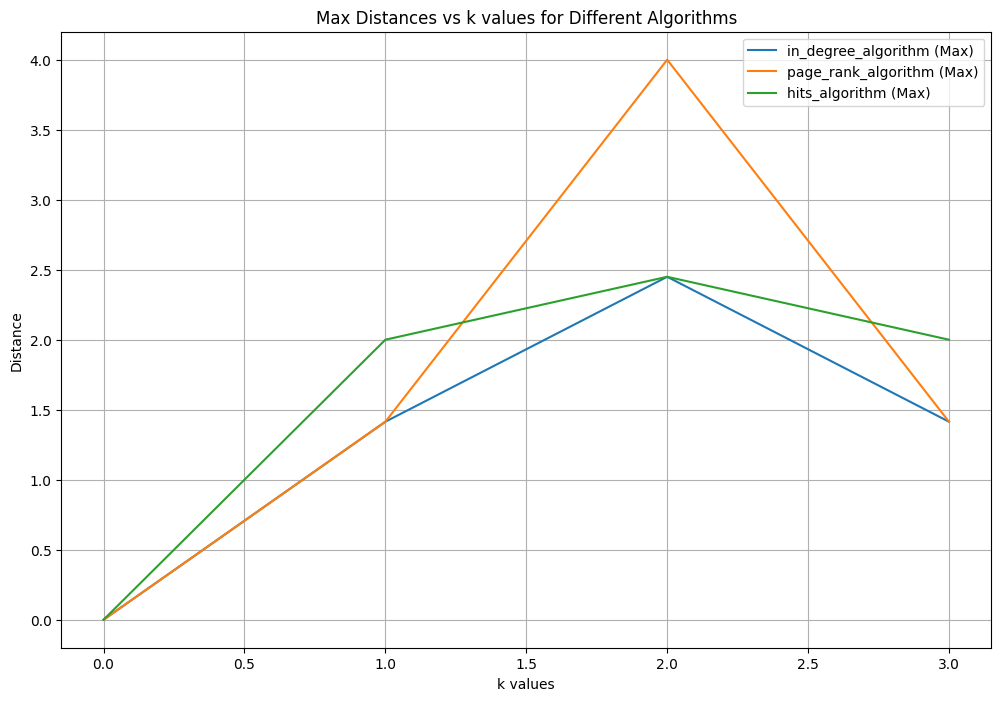

In [62]:
# Paremeters are changed here
list_of_algorithms = [in_degree_algorithm, page_rank_algorithm, hits_algorithm]
graph_size = 5
graph_connectedness = 0.3
k_values = range(0,4)
original_graph = generate_graph(graph_size,graph_connectedness)

adjacency_original = nx.adjacency_matrix(original_graph).todense()
results = {algorithm.__name__: {'k_values': [], 'max_distances': []} for algorithm in list_of_algorithms}

# One random combination is chosen
for k in k_values:
    gi = generate_indices(adjacency_original,k)
    random_combination = random.choice(gi)
    combinations_dict[k] = [random_combination]

# For each algorithm compute the ranking given the indices and return the euclidean distance
for algorithm in tqdm(list_of_algorithms):
    max_distances = []
    min_distances = []
    for k in k_values:
        max_distance, _, _, _, _ = find_highest_distance_after_changes(original_graph, combinations_dict[k], algorithm)
        max_distances.append(max_distance)
    results[algorithm.__name__]['k_values'] = list(k_values)
    results[algorithm.__name__]['max_distances'] = max_distances

# Plotting
nx.draw(original_graph)
plt.figure(figsize=(12, 8))

for algorithm_name, data in results.items():
    plt.plot(data['k_values'], data['max_distances'], label=f'{algorithm_name} (Max)')

plt.xlabel('k values')
plt.ylabel('Distance')
plt.title('Max Distances vs k values for Different Algorithms')
plt.legend()
plt.grid()
plt.show()

## Experiment 2:
Same as the experiment above but now for different graph sizes and fixed k value.

Takes a while to run

100%|██████████| 3/3 [00:00<00:00, 185.21it/s]


100%|██████████| 3/3 [00:00<00:00,  5.29it/s]


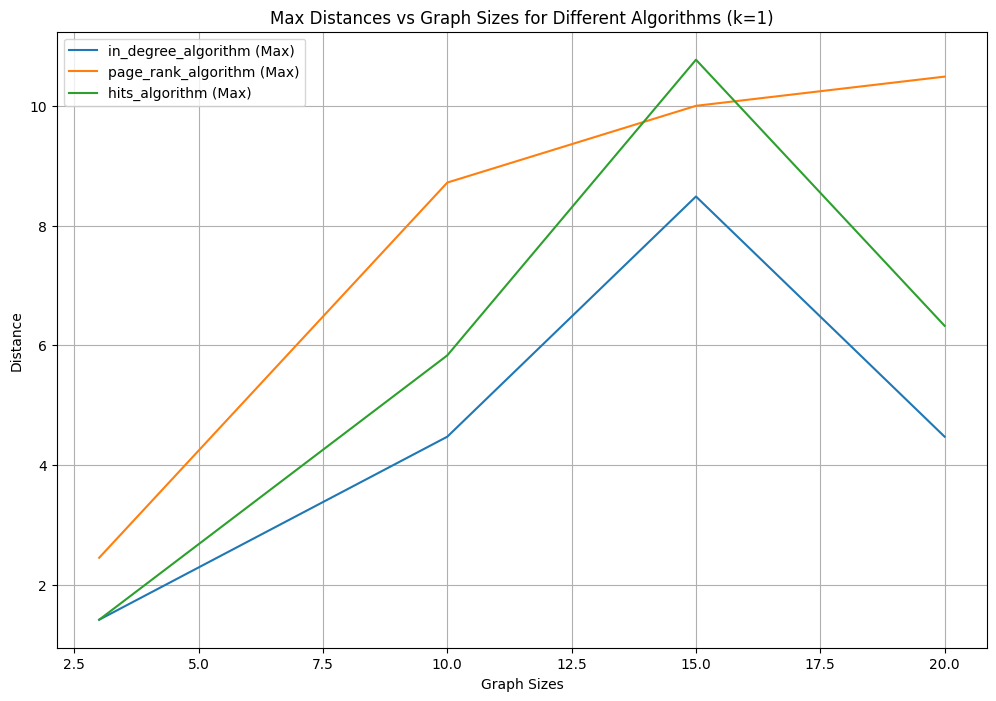

In [64]:
# Paremeters are changed here
list_of_algorithms = [in_degree_algorithm, page_rank_algorithm, hits_algorithm]
graph_sizes = [3, 10, 15,20]
k = 1  # Fixed k value
graph_connectedness = 0.3

results = {algorithm.__name__: {'algorithm_values': [], 'max_distances': []} for algorithm in list_of_algorithms}

for size in graph_sizes:
    original_graph = generate_graph(size, graph_connectedness)
    adjacency_original = nx.adjacency_matrix(original_graph).todense()
    combinations_dict = {}
    combinations_dict[k] = generate_indices(adjacency_original,k)

    for algorithm in tqdm(list_of_algorithms):
        max_distance, _, _, _, _ = find_highest_distance_after_changes(original_graph, combinations_dict[k], algorithm)
        results[algorithm.__name__]['algorithm_values'].append(max_distance)

# Plotting
plt.figure(figsize=(12, 8))

for algorithm_name, data in results.items():
    plt.plot(graph_sizes, data['algorithm_values'], label=f'{algorithm_name} (Max)')

plt.xlabel('Graph Sizes')
plt.ylabel('Distance')
plt.title('Max Distances vs Graph Sizes for Different Algorithms (k=1)')
plt.legend()
plt.grid()
plt.show()

## Experiment 3

We alter the graph by modifying percentage of the edjes, either by adding or removing an edge

In [65]:
# Function to inject noise into the graph by modifying a percentage of edges
def inject_noise(graph, noise_percentage):
    modified_graph = graph.copy()
    edges = list(modified_graph.edges())
    num_edges_to_modify = int(len(edges) * (noise_percentage / 100.0))

    # Randomly select edges to modify
    edges_to_modify = random.sample(edges, num_edges_to_modify)

    for edge in edges_to_modify:
        # Remove an edge if exists
        if modified_graph.has_edge(edge[0], edge[1]):
            modified_graph.remove_edge(edge[0], edge[1])
        else:
            modified_graph.add_edge(edge[0], edge[1])

    return modified_graph

# Function to perform the ranking experiment with noise injection
def experiment_with_noise(original_graph, noise_percentage_values, algorithms):
    # Generate a single noisy graph for all algorithms
    results = {algorithm.__name__: {'noise_percentages': [], 'max_distances': []} for algorithm in algorithms}

    for noise in tqdm(noise_percentage_values):
        noisy_graph = inject_noise(original_graph, noise)

        for algorithm in algorithms:
            distance = calculate_distance(original_graph, noisy_graph, algorithm)
            
            results[algorithm.__name__]['noise_percentages'].append(noise)
            results[algorithm.__name__]['max_distances'].append(distance)

    return results

# Function to calculate distance for a specific algorithm
def calculate_distance(original_graph, noisy_graph, algorithm):
    original_ranking = algorithm(nx.adjacency_matrix(original_graph).todense())
    noisy_ranking = algorithm(nx.adjacency_matrix(noisy_graph).todense())

    distance = vector_distance(original_ranking, noisy_ranking)
    return distance

100%|██████████| 100/100 [00:06<00:00, 14.65it/s]


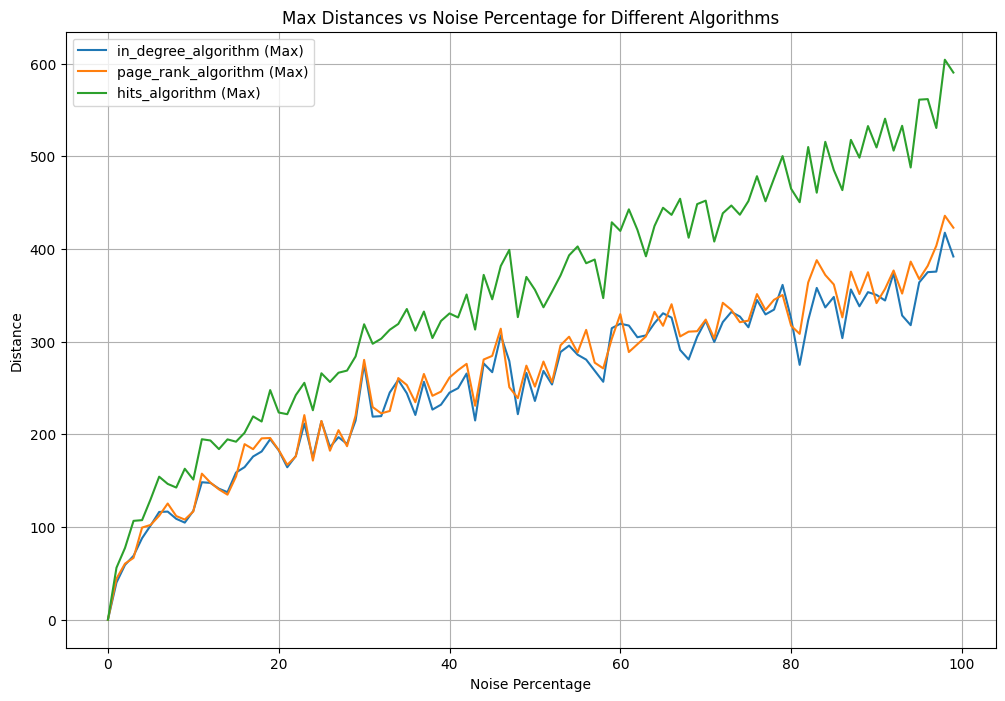

In [66]:
# Parameters
graph_size = 100
graph_connectedness = 0.3
noise_percentage_values = list(range(0, 100))  # Convert range to a list
list_of_algorithms = [in_degree_algorithm, page_rank_algorithm,hits_algorithm]
original_graph = generate_graph(graph_size, graph_connectedness)

# Perform the experiment
results = experiment_with_noise(original_graph, noise_percentage_values, list_of_algorithms)

plt.figure(figsize=(12, 8))

for algorithm_name, data in results.items():
    plt.plot(data['noise_percentages'], data['max_distances'], label=f'{algorithm_name} (Max)')

plt.xlabel('Noise Percentage')
plt.ylabel('Distance')
plt.title('Max Distances vs Noise Percentage for Different Algorithms')
plt.legend()
plt.grid()
plt.show()

Same as experiment above but normalizing distance between pagerank and in-degree to see their difference

100%|██████████| 100/100 [00:02<00:00, 35.65it/s]


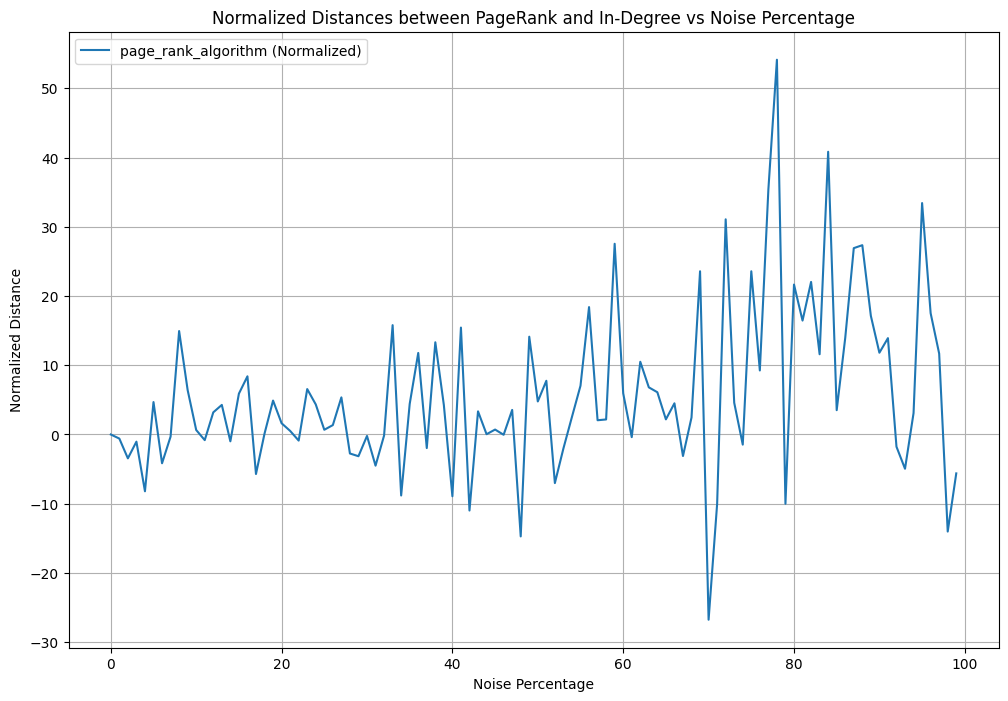

In [67]:
graph_size = 100
graph_connectedness = 0.3
noise_percentage_values = list(range(0, 100))  # Convert range to a list
list_of_algorithms = [in_degree_algorithm, page_rank_algorithm]
original_graph = generate_graph(graph_size, graph_connectedness)

results = experiment_with_noise(original_graph, noise_percentage_values, list_of_algorithms)

plt.figure(figsize=(12, 8))

for algorithm_name, data in results.items():
    if algorithm_name == 'page_rank_algorithm':
        # Subtracting In-Degree distance from PageRank distance
        in_degree_distances = results['in_degree_algorithm']['max_distances']
        normalized_distances = [pr_distance - in_degree_distance for pr_distance, in_degree_distance in zip(data['max_distances'], in_degree_distances)]
        plt.plot(data['noise_percentages'], normalized_distances, label=f'{algorithm_name} (Normalized)')

plt.xlabel('Noise Percentage')
plt.ylabel('Normalized Distance')
plt.title('Normalized Distances between PageRank and In-Degree vs Noise Percentage')
plt.legend()
plt.grid()
plt.show()